In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import json
import io
import subprocess

#### Load data

In [53]:
# Get file from the branch general-exploration
RailLine = subprocess.run(
    ["git", "show", "main:data/cleaned/RailLines.geojson"],
    capture_output=True,
    text=True,
    check=True
)

rail_line = gpd.read_file(io.StringIO(RailLine.stdout))
# rail_line = rail_line.to_crs(3857)
# rail_line = gpd.read_file('dsa4264-lta-geospatial/data/cleaned/RailLines.geojson')
print(rail_line.head())
rail_line.crs

    Name                                        Description  GroundLevel  \
0  kml_1  <center><table><tr><th colspan='2' align='cent...  ABOVEGROUND   
1  kml_2  <center><table><tr><th colspan='2' align='cent...  ABOVEGROUND   
2  kml_3  <center><table><tr><th colspan='2' align='cent...  ABOVEGROUND   
3  kml_4  <center><table><tr><th colspan='2' align='cent...  ABOVEGROUND   
4  kml_5  <center><table><tr><th colspan='2' align='cent...  ABOVEGROUND   

  RailType                                           geometry  
0      MRT  LINESTRING Z (103.7365 1.35301 0, 103.73649 1....  
1      MRT  LINESTRING Z (103.73708 1.35164 0, 103.73768 1...  
2      MRT  LINESTRING Z (103.71328 1.35252 0, 103.71327 1...  
3      MRT  LINESTRING Z (103.7132 1.35265 0, 103.71318 1....  
4      MRT  LINESTRING Z (103.70767 1.34888 0, 103.70767 1...  


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [54]:
# Get file from the branch general-exploration
RailStation = subprocess.run(
    ["git", "show", "main:data/cleaned/RailStationsMerged.geojson"],
    capture_output=True,
    text=True,
    check=True
)

rail_stn = gpd.read_file(io.StringIO(RailStation.stdout))
# .to_crs(3857)
# rail_stn = gpd.read_file('dsa4264-lta-geospatial/data/cleaned/RailStationsMerged.geojson')
print(rail_stn.head())



      Name                                        Description StationType  \
0  kml_105  <center><table><tr><th colspan='2' align='cent...         MRT   
1  kml_154  <center><table><tr><th colspan='2' align='cent...         MRT   
2    kml_1  <center><table><tr><th colspan='2' align='cent...         MRT   
3  kml_163  <center><table><tr><th colspan='2' align='cent...         MRT   
4  kml_243  <center><table><tr><th colspan='2' align='cent...         MRT   

      StationName StationCode    StationLine  \
0       Admiralty        NS10    North-South   
1        Aljunied         EW9      East-West   
2      Ang Mo Kio        NS16    North-South   
3   Aviation Park         CR2   Cross Island   
4  Bahar Junction         JS7  Jurong Region   

                                            geometry  
0  POLYGON Z ((103.80013 1.44004 0, 103.80003 1.4...  
1  POLYGON Z ((103.88373 1.31643 0, 103.88374 1.3...  
2  POLYGON Z ((103.84988 1.36925 0, 103.84976 1.3...  
3  POLYGON Z ((104.0021 1.37

#### Bus LineStrings

In [4]:
# Get file from the branch general-exploration
BusRoutes = subprocess.run(
    ["git", "show", "main:data/cleaned/BusRoutes.json"],
    capture_output=True,
    text=True,
    check=True
)

data = pd.read_json(io.StringIO(BusRoutes.stdout), encoding="utf-8", lines=True, chunksize=1000)
# data = pd.read_json("dsa4264-lta-geospatial/data/cleaned/BusRoutes.json", encoding="utf-8", lines=True, chunksize=1000)

# Combine chunks into a dataframe
df_list = []
for chunk in data:
    df_list.append(chunk)

# Concatenate all chunks into a single dataframe
bus_routes = pd.concat(df_list, ignore_index=True)
bus_routes = bus_routes[bus_routes['Direction']==1]
bus_routes = bus_routes[['ServiceNo', 'BusStopCode', 'StopSequence', 'Distance']]
print(bus_routes.head())

  ServiceNo  BusStopCode  StopSequence  Distance
0        10        75009             1       0.0
1        10        76059             2       0.6
2        10        76069             3       1.1
3        10        96289             4       2.3
4        10        96109             5       2.7


In [5]:
# Get file from the branch general-exploration
BusStops = subprocess.run(
    ["git", "show", "main:data/cleaned/BusStops.geojson"],
    capture_output=True,
    text=True,
    check=True
)

bus_stops = gpd.read_file(io.StringIO(BusStops.stdout)).to_crs(4326)

# Load BusStops.geojson using GeoPandas
# bus_stops = gpd.read_file('dsa4264-lta-geospatial/data/cleaned/BusStops.geojson')
print(bus_stops.head())


   BUS_STOP_N BUS_ROOF_N         LOC_DESC                   geometry
0       65059        B12     ST ANNE'S CH   POINT (103.9013 1.39303)
1       16171        B06  YUSOF ISHAK HSE  POINT (103.77437 1.29892)
2       61101        NIL          BLK 120   POINT (103.8637 1.33564)
3        1239        B01     SULTAN PLAZA  POINT (103.86165 1.30285)
4       17269        B01          BLK 730  POINT (103.76264 1.30492)


In [6]:
## Merge Bus Stop Coordinates with Bus Routes
# Ensure that BusStopCode is of the same type for both DataFrames (string)
bus_stops['BusStopCode'] = bus_stops['BUS_STOP_N'].astype(str)
bus_routes['BusStopCode'] = bus_routes['BusStopCode'].astype(str)

# Merge bus_routes with bus_stops to get geometry for each bus stop
merged_bus_data = bus_routes.merge(bus_stops[['BusStopCode', 'geometry']], on='BusStopCode', how='left')

# Drop rows without geometry
merged_bus_data = merged_bus_data.dropna(subset=['geometry'])

# Convert to GeoDataFrame
bus_routes_geo = gpd.GeoDataFrame(merged_bus_data, geometry='geometry')
# bus_routes_geo.to_crs(3857)
bus_routes_geo.set_crs(epsg=4326, inplace=True)
bus_routes_geo.head()

,ServiceNo,BusStopCode,StopSequence,Distance,geometry
0,10,75009,1,0.0,POINT (103.94364 1.3548)
1,10,76059,2,0.6,POINT (103.94164 1.35303)
2,10,76069,3,1.1,POINT (103.9421 1.34861)
3,10,96289,4,2.3,POINT (103.94836 1.34007)
4,10,96109,5,2.7,POINT (103.95069 1.33732)


#### Segment Bus Routes using the 'Distance' column

In [12]:
segmented_bus_routes = {}

# Group by ServiceNo
for service_no, group in bus_routes_geo.groupby('ServiceNo'):
    group = group.sort_values('Distance')  # Ensure stops are in sequence
    points = group['geometry'].tolist()
    codes = group['BusStopCode'].tolist()
    distances = group['Distance'].tolist()

    # Store all bus stop codes and points for the route
    all_stops_data = {
        'BusStopCodes': codes,
        'BusStopPoints': points
    }

    # Initialize segments
    segments = []
    current_segment_points = [points[0]]  # Start with the first point
    current_distance = 0.0

    # Create segments based on the Distance column
    for i in range(1, len(points)):
        segment_distance = distances[i] - distances[i - 1]

        if current_distance + segment_distance <= 1.0:
            # Add the point to the current segment
            current_segment_points.append(points[i])
            current_distance += segment_distance
        else:
            # Create a LineString if the segment has more than one point
            if len(current_segment_points) > 1:
                segments.append(LineString(current_segment_points))

            # Reset for the new segment
            current_segment_points = [points[i]]
            current_distance = 0.0

    # Add the final segment if it has more than one point
    if len(current_segment_points) > 1:
        segments.append(LineString(current_segment_points))

    # Store the route data in the dictionary
    segmented_bus_routes[service_no] = {
        'segments': segments,
        **all_stops_data  # Include bus stop codes and points
    }

segmented_bus_routes['10']

{'segments': [<LINESTRING (103.944 1.355, 103.942 1.353)>,
  <LINESTRING (103.948 1.34, 103.951 1.337, 103.95 1.334)>,
  <LINESTRING (103.949 1.333, 103.947 1.332, 103.949 1.329, 103.951 1.327)>,
  <LINESTRING (103.953 1.324, 103.954 1.323, 103.955 1.321, 103.955 1.32)>,
  <LINESTRING (103.951 1.318, 103.948 1.317, 103.945 1.316, 103.943 1.315)>,
  <LINESTRING (103.941 1.315, 103.937 1.314, 103.936 1.314)>,
  <LINESTRING (103.932 1.314, 103.928 1.313, 103.925 1.313)>,
  <LINESTRING (103.922 1.312, 103.919 1.311, 103.917 1.31, 103.914 1.309)>,
  <LINESTRING (103.911 1.309, 103.906 1.307, 103.903 1.304)>,
  <LINESTRING (103.902 1.304, 103.899 1.302, 103.897 1.304)>,
  <LINESTRING (103.895 1.307, 103.891 1.309)>,
  <LINESTRING (103.888 1.308, 103.885 1.307)>,
  <LINESTRING (103.88 1.307, 103.875 1.307)>,
  <LINESTRING (103.863 1.3, 103.858 1.296)>,
  <LINESTRING (103.855 1.292, 103.853 1.284)>,
  <LINESTRING (103.851 1.281, 103.85 1.278, 103.848 1.275)>,
  <LINESTRING (103.841 1.272, 103.

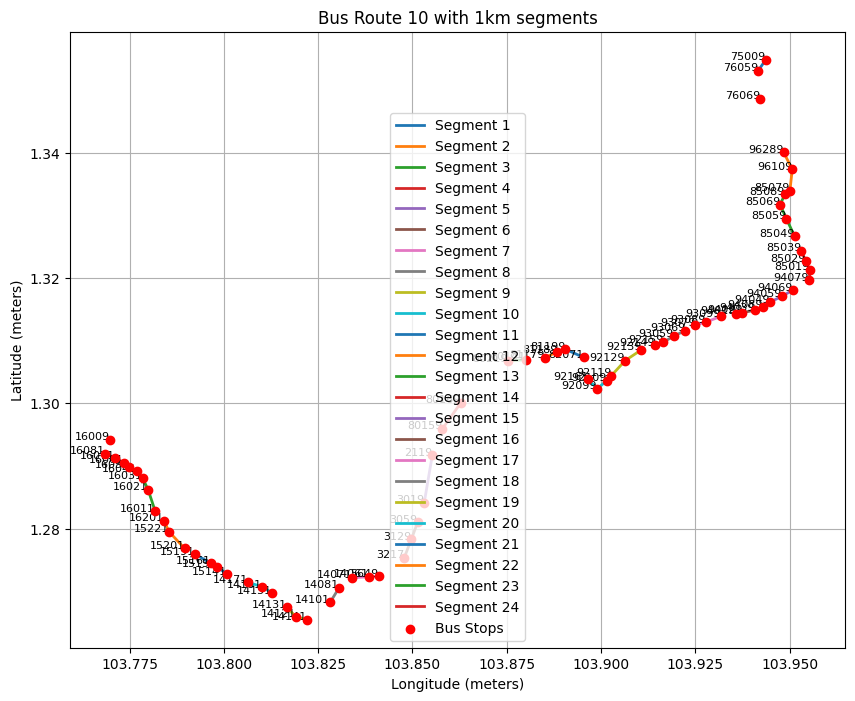

Segment 1: LINESTRING (103.94364418358533 1.354801893645436, 103.94164209835643 1.353034334226438)
Segment 2: LINESTRING (103.94836154091041 1.340074163765727, 103.95068597843446 1.337322324275546, 103.95005176260254 1.333907369175231)
Segment 3: LINESTRING (103.94869187789904 1.333321405759147, 103.94746166801366 1.331684633780343, 103.94913479068303 1.329424785231772, 103.95130222754862 1.326650611890011)
Segment 4: LINESTRING (103.95303047564109 1.324365461735205, 103.95430933616872 1.322630457372143, 103.95536301892798 1.321296362131978, 103.95518222102771 1.319605937398408)
Segment 5: LINESTRING (103.95080425310769 1.31806489090757, 103.9479119733712 1.317051828098025, 103.94472917340372 1.316143408661592, 103.94292769430345 1.31532839652944)


In [13]:
target_line = "10"  # change to visualize other lines

segmented_data = segmented_bus_routes[target_line]

mrt_segments = segmented_data['segments']
station_points = segmented_data['BusStopPoints']
station_names = segmented_data['BusStopCodes']

# Visualize the segments on the map
plt.figure(figsize=(10, 8))

# Plot each segment in a different color
for idx, segment in enumerate(mrt_segments):
    x_seg, y_seg = segment.xy  # Extract x and y coordinates for the segment
    plt.plot(x_seg, y_seg, label=f'Segment {idx+1}', linewidth=2)

# Plot the station points
station_x = [point.x for point in station_points]
station_y = [point.y for point in station_points]
plt.scatter(station_x, station_y, color='red', label='Bus Stops', zorder=5)

# Annotate the station names
for i, name in enumerate(station_names):
    plt.text(station_x[i], station_y[i], name, fontsize=8, ha='right')

# Set the title and labels
plt.title(f'Bus Route {target_line} with 1km segments')
plt.xlabel('Longitude (meters)')
plt.ylabel('Latitude (meters)')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Print the first few segments for verification
for idx, segment in enumerate(mrt_segments[:5]):  # Print first 5 segments
    print(f"Segment {idx+1}: {segment}")

#### Train LineStrings

In [34]:
rail_stn = rail_stn.to_crs(epsg=32648)

#  Group the stations by MRT line
station_groups = rail_stn.groupby('StationLine')

# Dictionary to store LineStrings for each MRT line
line_strings_per_station_line = {}

# Iterate over each MRT line group and create a sorted LineString
for line_name, group in station_groups:
    # Sort the stations by their longitude (x-coordinate) or latitude (y-coordinate)
    group['centroid_x'] = group.geometry.centroid.x  # Get x-coordinate of the centroid
    sorted_group = group.sort_values('centroid_x')  # Sort by the x-coordinate

    # Extract the station centroids, names, and codes
    station_points = sorted_group.geometry.centroid.tolist()
    station_names = sorted_group['StationName'].tolist()
    station_codes = sorted_group['StationCode'].tolist()

    # Initialize a set to track unique station codes
    unique_station_codes = set()

    # Initialize lists to store filtered stations (with unique codes)
    filtered_station_points = []
    filtered_station_names = []
    filtered_station_codes = []

    #Filter out stations with duplicate station codes and None values
    for point, name, code in zip(station_points, station_names, station_codes):
        if code not in unique_station_codes and point is not None:
            # Add the station to the filtered lists
            filtered_station_points.append(point)
            filtered_station_names.append(name)
            filtered_station_codes.append(code)

            # Mark this station code as seen
            unique_station_codes.add(code)

    # create a LineString from the filtered station points
    if filtered_station_points:  # Check if we have valid points
        try:
            mrt_line = LineString(filtered_station_points)
        
            # Store the data in the dictionary
            line_strings_per_station_line[line_name] = {
                'LineString': mrt_line,
                'StationNames': filtered_station_names,
                'StationCodes': filtered_station_codes,
                'StationPoints': filtered_station_points
            }
        except TypeError as e:
            print(f"Error creating LineString for {line_name}: {e}")
            continue

print(line_strings_per_station_line)
# for line_name, line_data in line_strings_per_station_line.items():
#     print(f"MRT Line: {line_name}")
#     print(f"  LineString: {line_data['LineString']}")
#     print(f"  Station Names: {line_data['StationNames']}")
#     print(f"  Station Codes: {line_data['StationCodes']}")
#     print(f"  Station Points (centroids): {line_data['StationPoints']}")
#     print("\n")

{'Bukit Panjang LRT': {'LineString': <LINESTRING (360309.027 153140.435, 360411.414 152601.551, 360829.656 152414...>, 'StationNames': ['Choa Chu Kang', 'South View', 'Keat Hong', 'Teck Whye', 'Phoenix', 'Bukit Panjang', 'Senja', 'Petir', 'Segar', 'Fajar', 'Pending', 'Bangkit'], 'StationCodes': ['BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP13', 'BP7', 'BP11', 'BP10', 'BP8', 'BP9'], 'StationPoints': [<POINT (360309.027 153140.435)>, <POINT (360411.414 152601.551)>, <POINT (360829.656 152414.918)>, <POINT (361346.739 152198.743)>, <POINT (361829.093 152415.808)>, <POINT (362235.186 152463.085)>, <POINT (362311.693 152865.997)>, <POINT (362789.705 152319.091)>, <POINT (363123.233 153424.677)>, <POINT (363254.156 153068.205)>, <POINT (363302.833 152138.828)>, <POINT (363456.769 152568.697)>]}, 'Circle': {'LineString': <LINESTRING (364470.674 141787.593, 364769.081 142992.291, 365375.618 144524...>, 'StationNames': ['Haw Par Villa', 'Kent Ridge', 'Buona Vista', 'Pasir Panjang', 'Holland Vil

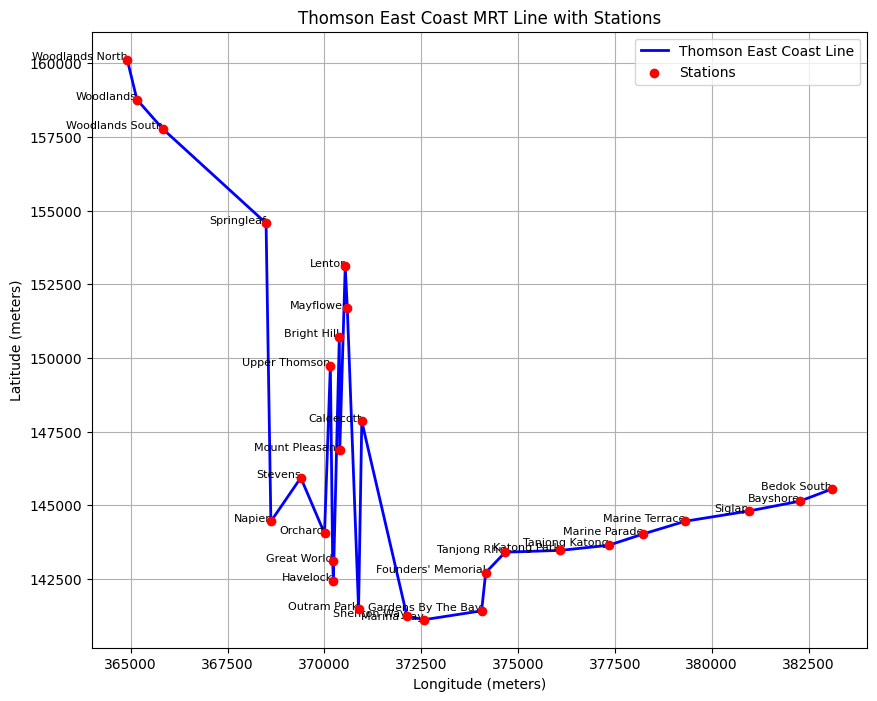

In [38]:
target_line = "Thomson East Coast" #change accordingly

# Check if the line exists in the processed data
if target_line in line_strings_per_station_line:
    line_data = line_strings_per_station_line[target_line]

    # Extract the LineString, station points, and station names
    mrt_line = line_data['LineString']
    station_points = line_data['StationPoints']
    station_names = line_data['StationNames']

    # Plot the MRT line
    plt.figure(figsize=(10, 8))
    
    # Plot the LineString representing the MRT line
    x, y = mrt_line.xy  # Extract x and y coordinates from the LineString
    plt.plot(x, y, label=f'{target_line} Line', color='blue', linewidth=2)
    
    # Plot the station points on the map
    station_x = [point.x for point in station_points]
    station_y = [point.y for point in station_points]
    plt.scatter(station_x, station_y, color='red', label='Stations', zorder=5)

    # Annotate the station names
    for i, name in enumerate(station_names):
        plt.text(station_x[i], station_y[i], name, fontsize=8, ha='right')

    # Set the title and labels
    plt.title(f'{target_line} MRT Line with Stations')
    plt.xlabel('Longitude (meters)')
    plt.ylabel('Latitude (meters)')
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.grid(True)
    plt.show()

else:
    print(f"No data available for MRT Line: {target_line}")

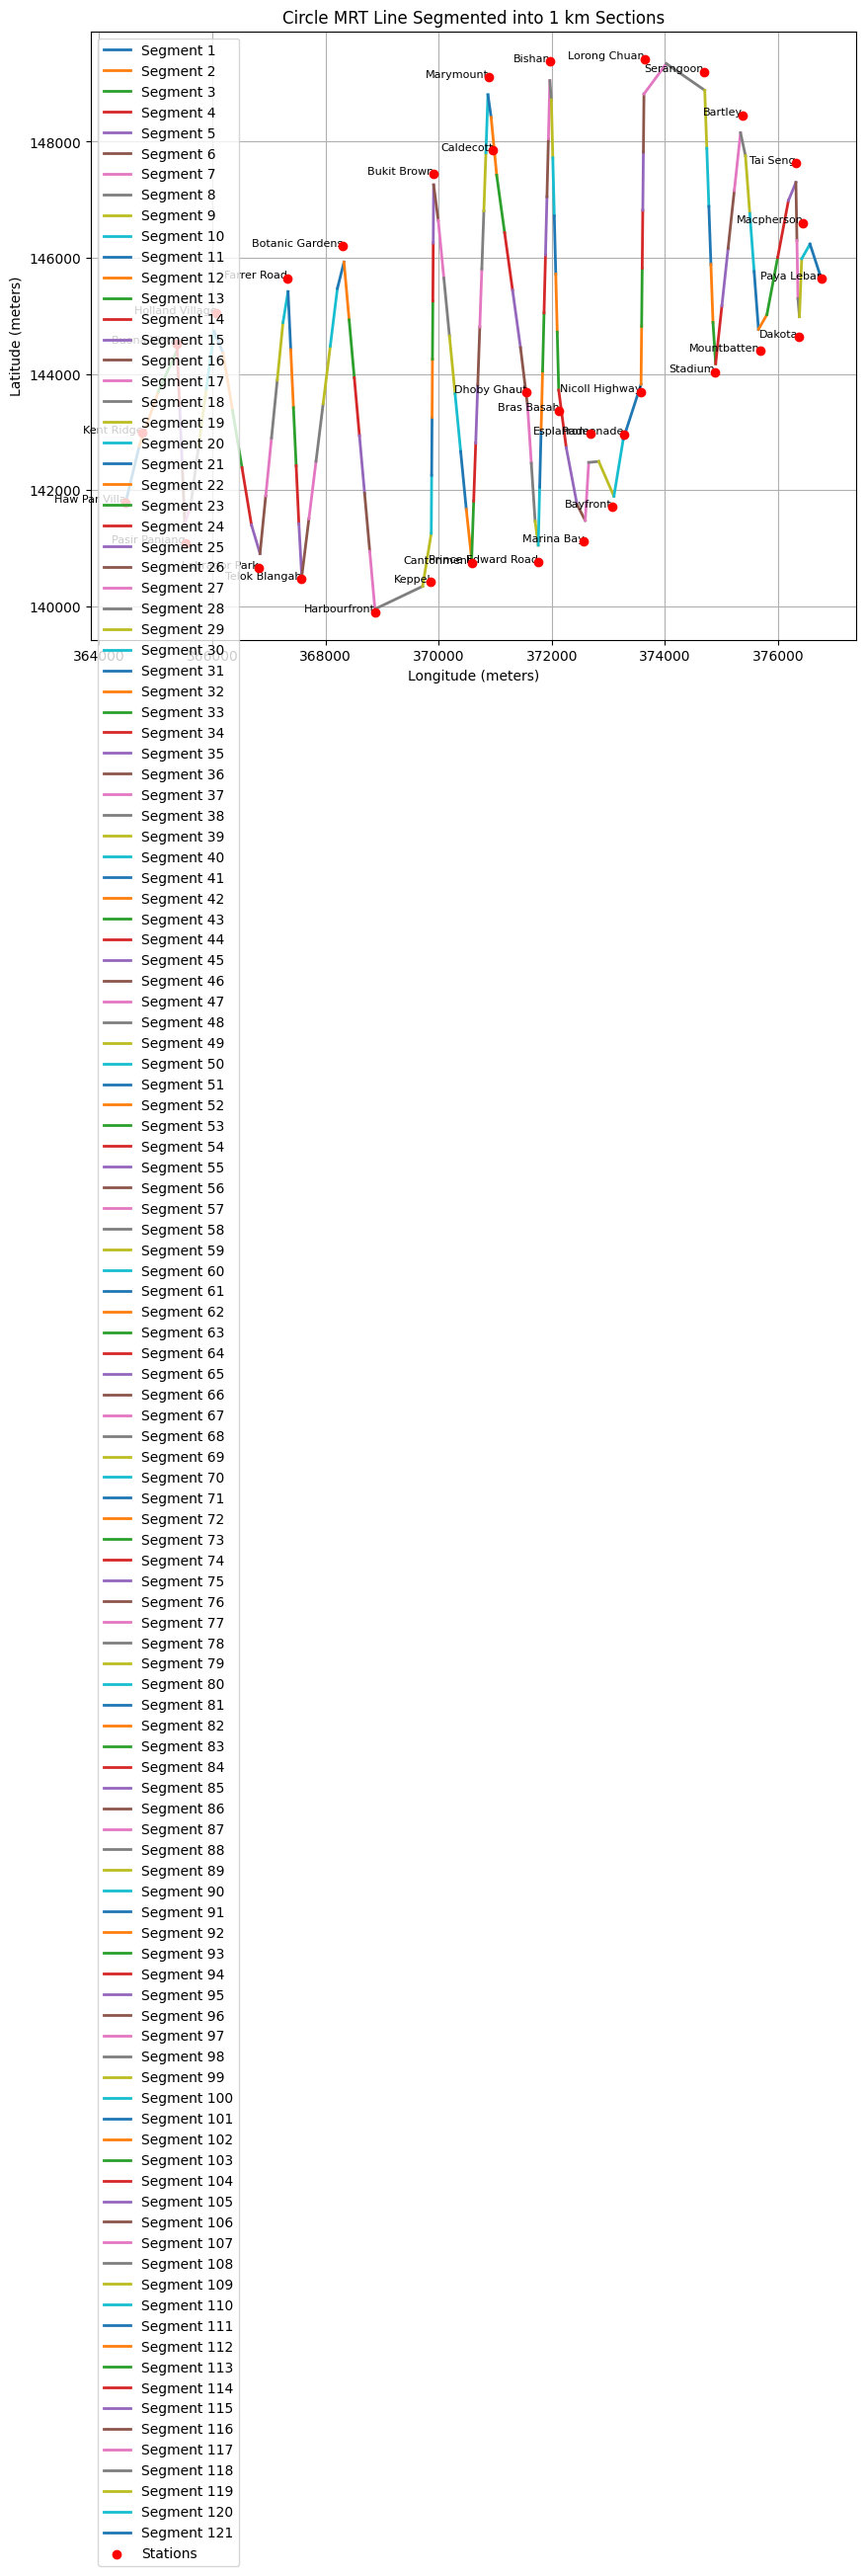

Segment 1: LINESTRING (364470.6736855947 141787.59347476804, 364711.1106371734 142758.2582327126)
Segment 2: LINESTRING (364711.1106371734 142758.2582327126, 365048.4832446423 143697.8795467186)
Segment 3: LINESTRING (365048.4832446423 143697.8795467186, 365380.6201322016 144412.6660921805)
Segment 4: LINESTRING (365380.6201322016 144412.6660921805, 365425.4997066951 143413.67368790842)
Segment 5: LINESTRING (365425.4997066951 143413.67368790842, 365470.3792811886 142414.68128363637)


In [37]:
# Function to segment a LineString into 1 km sections
def segment_line_by_distance(line, distance=1000):
    segments = []  # List to store the line segments
    current_distance = 0  # Start distance

    # Iterate over the entire length of the line and create segments of the specified distance
    while current_distance < line.length:
        # Calculate the start and end points for each segment
        start_point = line.interpolate(current_distance)
        end_point = line.interpolate(min(current_distance + distance, line.length))
        
        # Create a LineString for the segment and add it to the list
        segments.append(LineString([start_point, end_point]))
        
        # Move to the next segment
        current_distance += distance

    return segments  # Return the list of 1 km line segments

# Dictionary to store segmented lines for each MRT line
segmented_lines_per_station_line = {}

# Iterate through each MRT line in the dataset
for line_name, line_info in line_strings_per_station_line.items():
    # Get the LineString and station details for each line
    mrt_line = line_info['LineString']
    station_points = line_info['StationPoints']
    station_names = line_info['StationNames']

    # Segment the MRT line into 1 km sections
    mrt_segments = segment_line_by_distance(mrt_line, 1000)

    # Store the segments for this MRT line
    segmented_lines_per_station_line[line_name] = {
        'segments': mrt_segments,
        'station_names': station_names,
        'station_points': station_points
    }

target_line = "Circle"  # change to visualize other lines
if target_line in segmented_lines_per_station_line:
    segmented_data = segmented_lines_per_station_line[target_line]

    mrt_segments = segmented_data['segments']
    station_points = segmented_data['station_points']
    station_names = segmented_data['station_names']

    # Visualize the segments on the map
    plt.figure(figsize=(10, 8))

    # Plot each segment in a different color
    for idx, segment in enumerate(mrt_segments):
        x_seg, y_seg = segment.xy  # Extract x and y coordinates for the segment
        plt.plot(x_seg, y_seg, label=f'Segment {idx+1}', linewidth=2)

    # Plot the station points
    station_x = [point.x for point in station_points]
    station_y = [point.y for point in station_points]
    plt.scatter(station_x, station_y, color='red', label='Stations', zorder=5)

    # Annotate the station names
    for i, name in enumerate(station_names):
        plt.text(station_x[i], station_y[i], name, fontsize=8, ha='right')

    # Set the title and labels
    plt.title(f'{target_line} MRT Line Segmented into 1 km Sections')
    plt.xlabel('Longitude (meters)')
    plt.ylabel('Latitude (meters)')

    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.grid(True)
    plt.show()

    # Print the first few segments for verification
    for idx, segment in enumerate(mrt_segments[:5]):  # Print first 5 segments
        print(f"Segment {idx+1}: {segment}")

else:
    print(f"No data available for MRT Line: {target_line}")

#### Compare each segment of the bus route to its nearest mrt line.

In [16]:
bus_routes_lines = (
    bus_routes_geo.groupby(['ServiceNo'])
    .apply(lambda x: LineString(x.sort_values('StopSequence')['geometry'].tolist()))
    .reset_index()
    .rename(columns={0: 'geometry'})
)
# Convert to GeoDataFrame
bus_routes_lines = gpd.GeoDataFrame(bus_routes_lines, geometry='geometry')

/var/folders/hx/j3t1dc5d6539d5c6zm67rnf00000gn/T/ipykernel_52686/4275758117.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bus_routes_geo.groupby(['ServiceNo'])


In [23]:
if bus_routes_lines.crs is None:
    bus_routes_lines = bus_routes_lines.set_crs(epsg=4326)

#Reproject bus routes to the same CRS as the MRT lines (UTM Zone 48N - EPSG:32648)
bus_routes_lines = bus_routes_lines.to_crs(epsg=32648)

mrt_buffers = {}  # Dictionary to store buffers for each MRT line
buffer_distance = 300
for line_name, line_data in line_strings_per_station_line.items():
    mrt_line = line_data['LineString']
    mrt_buffer = mrt_line.buffer(buffer_distance)  # Create a buffer around the MRT line
    mrt_buffers[line_name] = mrt_buffer  # Store the buffer

#Check if any bus route is near any MRT line buffer
overlap_results = []

for line_name, mrt_buffer in mrt_buffers.items():
    for idx, bus_route in bus_routes_lines.iterrows():
        if bus_route.geometry.intersects(mrt_buffer):
            overlap_length = bus_route.geometry.intersection(mrt_buffer).length  # Get overlap length
            overlap_results.append({
                'MRT_Line': line_name,
                'Bus_ServiceNo': bus_route['ServiceNo'],
                # 'Direction': bus_route['Direction'],  # Keep track of direction for later
                'Bus_Route_Length_m': bus_route.geometry.length,  # Length of the bus route in meters
                'Overlap_Length_m': overlap_length  # Overlap length in meters
            })

overlap_df = pd.DataFrame(overlap_results)

#Sort the DataFrame by 'Overlap_Length_m' in descending order
overlap_df_sorted = overlap_df.sort_values(by='Overlap_Length_m', ascending=False)

# For each bus service, keep only the direction with the greater overlap
# Group by 'Bus_ServiceNo' and 'Direction', take the max 'Overlap_Length_m' for each service
overlap_df_max = overlap_df_sorted.groupby(['Bus_ServiceNo']).apply(lambda x: x.loc[x['Overlap_Length_m'].idxmax()]).reset_index(drop=True)

# Drop duplicates for each 'Bus_ServiceNo' while keeping only the row with the maximum 'Overlap_Length_m'
overlap_df_unique = overlap_df_max.sort_values(by='Overlap_Length_m', ascending=False).drop_duplicates(subset=['Bus_ServiceNo'], keep='first')

# Output the final DataFrame
overlap_df_unique

/var/folders/hx/j3t1dc5d6539d5c6zm67rnf00000gn/T/ipykernel_52686/783497063.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  overlap_df_max = overlap_df_sorted.groupby(['Bus_ServiceNo']).apply(lambda x: x.loc[x['Overlap_Length_m'].idxmax()]).reset_index(drop=True)


,MRT_Line,Bus_ServiceNo,Bus_Route_Length_m,Overlap_Length_m
267,Thomson East Coast,36,44616.364459,22223.790654
339,East-West,63,33442.621667,19492.797271
342,Circle,64,27108.231063,19356.868635
156,Circle,195,24937.311104,19350.793083
269,Thomson East Coast,36B,25675.006850,19118.469794
...,...,...,...,...
392,North-South,803,2506.308145,245.154859
395,North-South,806,4633.388118,245.154859
443,Sengkang LRT,86A,5380.591998,203.472393
505,North-South,962C,1250.818701,137.683073


help pls

In [60]:
x = segmented_bus_routes['36']['segments']
# mrt = line_strings_per_station_line['Thomson East Coast']['LineString'].buffer(300)

t = 0
for segment in x:
    for idx,row in rail_line.iterrows():
        line = row['geometry']
        segment_buffered = segment.buffer(300)
        if segment_buffered.intersects(line): t+=1
        # elif segment_buffered.touches(mrt): t+=1
        # print(line)

print(t)

28665


In [25]:
results = []

for idx,row in overlap_df_unique.iterrows():
    bus_segments = segmented_bus_routes[row['Bus_ServiceNo']]['segments']
    mrt_line = line_strings_per_station_line[row['MRT_Line']]['LineString']
    mrt_line_buffered = mrt_line.buffer(300)

    total_segment_count = len(bus_segments)
    overlapping_segment_count = 0

    for segment in bus_segments:
        if segment.intersects(mrt_line_buffered):
            overlapping_segment_count += 1 
    
    pct_overlap_segments = (overlapping_segment_count/total_segment_count)*100 if total_segment_count>0 else 0
    
    results.append({
        'Bus_ServiceNo': row['Bus_ServiceNo'],
        'MRT_Line': row['MRT_Line'],
        'Bus_Route_Length_m': row['Bus_Route_Length_m'],
        'Overlap_Length_m': row['Overlap_Length_m'],
        'Coverage_Percentage': pct_overlap_segments
    })

results_df = pd.DataFrame(results)
results_df_filtered = results_df[results_df['Coverage_Percentage']>0]
results_df_sorted = results_df_filtered.sort_values(by='Coverage_Percentage', ascending=False)
results_df_sorted


,Bus_ServiceNo,MRT_Line,Bus_Route_Length_m,Overlap_Length_m,Coverage_Percentage
